In [ ]:
!pip uninstall -y torch-scatter torch-sparse torch-cluster torch-spline-conv
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch torchvision torchaudio torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.0.1+cu117.html



Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.0/494.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.9/750.9 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.1/208.1 kB 5.4 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu117.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/

In [ ]:
!pip install --force-reinstall torch-geometric

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import networkx as nx
from sklearn.preprocessing import LabelEncoder
import numpy as np


file_path = '/content/lncRNA_disease.csv'

df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Quick data exploration
print('Dataset Preview:')
print(df.head())
print('\nColumns:', df.columns)
print('\nData Types:', df.dtypes)
print('\nMissing Values:', df.isnull().sum())

# Encoding categorical variables
le_lncRNA = LabelEncoder()
le_disease = LabelEncoder()

df['lncRNA_Encoded'] = le_lncRNA.fit_transform(df['lncRNA'])
df['Disease_Encoded'] = le_disease.fit_transform(df['Disease_Name'])

print('\nEncoded lncRNAs:', df['lncRNA_Encoded'].unique()[:5])
print('Encoded Diseases:', df['Disease_Encoded'].unique()[:5])

# Analyze relationships
num_interactions = len(df)
num_lncrnas = len(df['lncRNA_Encoded'].unique())
num_diseases = len(df['Disease_Encoded'].unique())

print(f'\nNumber of lncRNA-Disease Interactions: {num_interactions}')
print(f'Number of Unique lncRNAs: {num_lncrnas}')
print(f'Number of Unique Diseases: {num_diseases}')

# Initial HIN structure
print('\nHIN Structure Preview:')
print(df[['lncRNA_Encoded', 'Disease_Encoded']].head())


/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOp

Dataset Preview:
        lncRNA               Disease_Name
0  ARHGAP5-AS1  Carcinoma, Hepatocellular
1       HOTTIP               Osteosarcoma
2       HOTTIP                     Glioma
3       HOTTIP             Retinoblastoma
4       HOTTIP          stomach carcinoma

Columns: Index(['lncRNA', 'Disease_Name'], dtype='object')

Data Types: lncRNA          object
Disease_Name    object
dtype: object

Missing Values: lncRNA          0
Disease_Name    0
dtype: int64

Encoded lncRNAs: [ 337 1293 1291 1298 1297]
Encoded Diseases: [ 52 256 137 297 430]

Number of lncRNA-Disease Interactions: 12133
Number of Unique lncRNAs: 5316
Number of Unique Diseases: 436

HIN Structure Preview:
   lncRNA_Encoded  Disease_Encoded
0             337               52
1            1293              256
2            1293              137
3            1293              297
4            1293              430


In [ ]:
import networkx as nx

# Initialize the Graph
G = nx.Graph()

# Add lncRNA and Disease Nodes
lncRNA_nodes = df['lncRNA_Encoded'].unique()
disease_nodes = df['Disease_Encoded'].unique()

# Explicitly set node types
for node in lncRNA_nodes:
    G.add_node(node, node_type='lncRNA')
for node in disease_nodes:
    G.add_node(node, node_type='disease')

# Add Edges for Known Interactions (Avoid duplicates)
edges = set(zip(df['lncRNA_Encoded'], df['Disease_Encoded']))
G.add_edges_from(edges)

# Summary of the HIN
print("\n✅ HIN Construction Complete!")
print(f"🔹 Total Nodes: {G.number_of_nodes()}")
print(f"🔹 Total Edges: {G.number_of_edges()}")
print(f"🔹 Example Edges: {list(G.edges)[:5]}")



✅ HIN Construction Complete!
🔹 Total Nodes: 5316
🔹 Total Edges: 9897
🔹 Example Edges: [(np.int64(337), 40), (np.int64(337), 4291), (np.int64(337), 52), (np.int64(337), 122), (np.int64(1293), 192)]


In [ ]:
# Node features and Edge index
import torch
import numpy as np

# Define embedding dimension
embedding_dim = 16

# Get the number of nodes
num_nodes = G.number_of_nodes()

# Initialize random node features for all nodes (lncRNAs + diseases)
node_features = torch.rand((num_nodes, embedding_dim), dtype=torch.float)

# Convert edges to tensor efficiently using numpy
edges_np = np.array(list(G.edges), dtype=np.int64).T  # Ensure shape is (2, num_edges)
edge_index = torch.tensor(edges_np, dtype=torch.long)

# Check the shapes for confirmation
print(f"✅ Node Feature Initialization Complete!")
print(f"🔹 Number of Nodes: {num_nodes}")
print(f"🔹 Node Features Shape: {node_features.shape}")
print(f"🔹 Edge Index Shape: {edge_index.shape}")
print(f"🔹 Sample Edge Index (First 5): \n{edge_index[:, :5]}")
`

✅ Node Feature Initialization Complete!
🔹 Number of Nodes: 5316
🔹 Node Features Shape: torch.Size([5316, 16])
🔹 Edge Index Shape: torch.Size([2, 9897])
🔹 Sample Edge Index (First 5): 
tensor([[ 337,  337,  337,  337, 1293],
        [  40, 4291,   52,  122,  192]])


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, BatchNorm

class GNNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNModel, self).__init__()
        self.gcn = GCNConv(in_channels, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)  # Batch Normalization
        self.gat = GATConv(hidden_channels, out_channels, heads=2, concat=False)
        self.bn2 = BatchNorm(out_channels)
        self.dropout = torch.nn.Dropout(0.3)

    def forward(self, x, edge_index):
        x = self.gcn(x, edge_index)
        x = self.bn1(x)  # Normalize after GCN
        x = F.relu(x)
        x = self.dropout(x)
        x = self.gat(x, edge_index)
        x = self.bn2(x)  # Normalize after GAT
        return x

# Model Initialization
model = GNNModel(embedding_dim, 32, 16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)  # Lower LR + Weight Decay-prevents overfitting

# Training Loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    out = model(node_features, edge_index)

    # Improved Loss: Cosine Similarity instead of MSE
    loss = 1 - F.cosine_similarity(out[edge_index[0]], out[edge_index[1]]).mean()

    loss.backward()  #back propagation
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)  # Gradient Clipping
    optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")


Epoch 1/20, Loss: 0.9441
Epoch 2/20, Loss: 0.8331
Epoch 3/20, Loss: 0.8412
Epoch 4/20, Loss: 0.8360
Epoch 5/20, Loss: 0.8892
Epoch 6/20, Loss: 0.9190
Epoch 7/20, Loss: 0.8459
Epoch 8/20, Loss: 0.8294
Epoch 9/20, Loss: 0.7195
Epoch 10/20, Loss: 0.7651
Epoch 11/20, Loss: 0.8125
Epoch 12/20, Loss: 0.7730
Epoch 13/20, Loss: 0.7515
Epoch 14/20, Loss: 0.8239
Epoch 15/20, Loss: 0.8791
Epoch 16/20, Loss: 0.7550
Epoch 17/20, Loss: 0.6697
Epoch 18/20, Loss: 0.7265
Epoch 19/20, Loss: 0.4813
Epoch 20/20, Loss: 0.6234


In [ ]:
print("Unique Encoded Disease IDs in le_disease:", sorted(le_disease.classes_))
print("First 10 Disease Encodings in DataFrame:\n", df[['Disease_Encoded', 'Disease_Name']].head(10))


Unique Encoded Disease IDs in le_disease: ['Abortion, Habitual', 'Abortion, Spontaneous', 'Acute Coronary Syndrome', 'Acute Kidney Injury', 'Acute Liver Injury', 'Acute Lung Injury', 'Adenocarcinoma', 'Adenocarcinoma Of Esophagus', 'Adenocarcinoma of Lung', 'Adenocarcinoma, Follicular', 'Adrenal Cortex Neoplasms', 'Adrenocortical Carcinoma', 'Aging', 'Alzheimer Disease', 'Ameloblastoma', 'Amyotrophic Lateral Sclerosis', 'Amyotrophic Lateral Sclerosis 7', 'Aortic Aneurysm, Abdominal', 'Aortic Aneurysm, Thoracic', 'Aortic Dissection', 'Aortic Valve, Calcification of', 'Arteriosclerosis Obliterans', 'Arthritis, Gouty', 'Arthritis, Juvenile', 'Arthritis, Psoriatic', 'Arthritis, Rheumatoid', 'Asthma', 'Atherosclerosis', 'Atrial Fibrillation', 'Autism Spectrum Disorder', 'B-cell acute lymphoblastic leukemia', 'Bacterial Infections', 'Behcet Syndrome', 'Bipolar Disorder', 'Bone Neoplasms', 'Bone-Invasive Pituitary Adenomas', 'Brain Injuries', 'Brain Injuries, Traumatic', 'Breast Cancer Lung M


🔮 Top 20 Newly Predicted lncRNA-Disease Interactions:
🧬 lncRNA: BEST3 ↔ 🦠 Disease: Sleep Apnea, Obstructive | Confidence: 0.9981
🧬 lncRNA: C5orf22 ↔ 🦠 Disease: oral squamous cell carcinoma | Confidence: 0.9979
🧬 lncRNA: CCL15-CCL14 ↔ 🦠 Disease: Arteriosclerosis Obliterans | Confidence: 0.9940
🧬 lncRNA: KDM4A-AS1 ↔ 🦠 Disease: Molecular Epidemiology | Confidence: 0.9918
🧬 lncRNA: ATP5ME ↔ 🦠 Disease: B-cell acute lymphoblastic leukemia | Confidence: 0.9904
🧬 lncRNA: HOTAIRM1-201 ↔ 🦠 Disease: ankylosing spondylitis 1 | Confidence: 0.9900
🧬 lncRNA: CENPO ↔ 🦠 Disease: B-cell acute lymphoblastic leukemia | Confidence: 0.9887
🧬 lncRNA: SNRPFP1 ↔ 🦠 Disease: Colonic Neoplasms | Confidence: 0.9856
🧬 lncRNA: AC015911.3 ↔ 🦠 Disease: Periodontitis | Confidence: 0.9848
🧬 lncRNA: ARPC1B-218 ↔ 🦠 Disease: COVID-19 | Confidence: 0.9822
🧬 lncRNA: ENSG00000223486 ↔ 🦠 Disease: Lupus Nephritis | Confidence: 0.9820
🧬 lncRNA: LNCV6_72936_PI430048170 ↔ 🦠 Disease: Cerebral Ischaemia/Reperfusion Injury | Confide

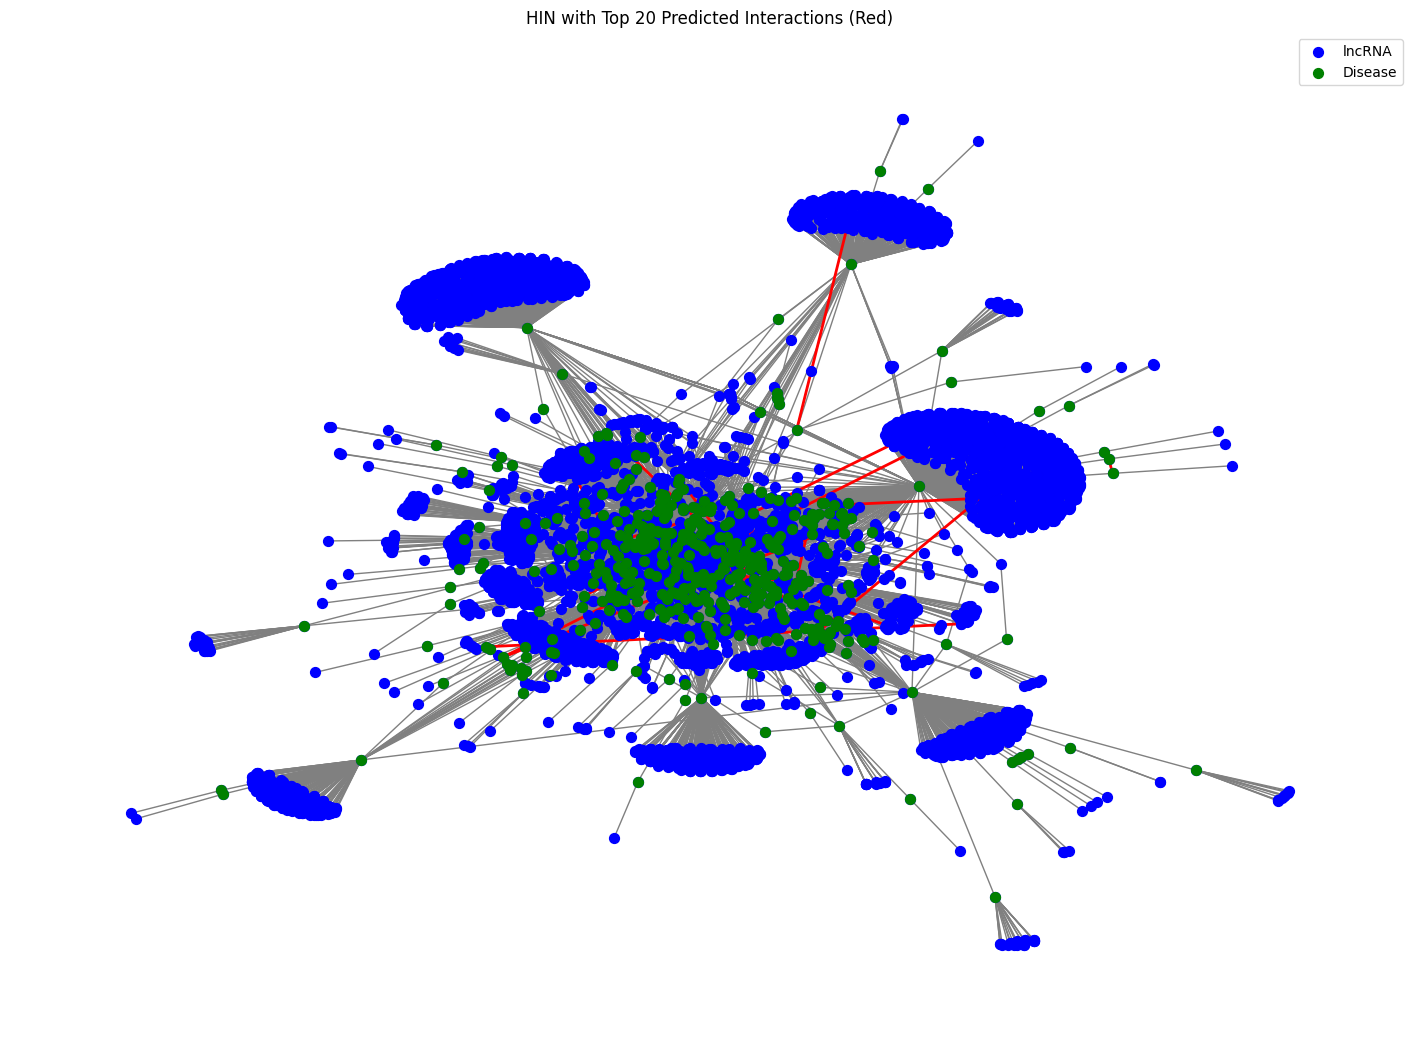

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import random
import torch

# np.random.seed(42)
# torch.manual_seed(42)

# Set model to evaluation mode
model.eval()
with torch.no_grad():
    node_embeddings = model(node_features, edge_index)

# Get valid encoded disease IDs from the dataset
valid_disease_ids = set(df['Disease_Encoded'].unique())

# Ensure new edges are sampled correctly
existing_edges = set(G.edges())
potential_edges = set()

# Use np.random instead of random for the fixed values

while len(potential_edges) < 2000:
    u = random.randint(0, df['lncRNA_Encoded'].max())
    v = random.choice(list(valid_disease_ids))

    if u != v and (u, v) not in existing_edges and (v, u) not in existing_edges:
        potential_edges.add((u, v))


# Convert to tensor for fast computation
potential_edges_tensor = torch.tensor(list(potential_edges), dtype=torch.long).t()

# Compute Similarity Scores Efficiently  #cosine similarity
similarity_scores = torch.cosine_similarity(
    node_embeddings[potential_edges_tensor[0]],
    node_embeddings[potential_edges_tensor[1]],
    dim=1
)

# Extracting Predicted Interactions
predicted_interactions = [
    (u, v, score.item()) for (u, v), score in zip(potential_edges, similarity_scores)
]
predicted_interactions.sort(key=lambda x: x[2], reverse=True)
top_predictions = predicted_interactions[:20]

#  Force Disease Name Retrieval
def get_disease_name(encoded_id):
    try:
        # Directly use inverse_transform if possible
        return le_disease.inverse_transform([encoded_id])[0]
    except ValueError:
        pass  # Move to next method if it fails

    # Try looking up in the DataFrame
    disease_lookup = df[df['Disease_Encoded'] == encoded_id]['Disease_Name'].values
    if len(disease_lookup) > 0:
        return disease_lookup[0]


    print(f"⚠ Warning: No match found for Disease ID {encoded_id}!")
    return f"🆔 Disease ID: {encoded_id}"

#  Ensure lncRNA Names Are Retrieved Correctly
def get_lncRNA_name(encoded_id):
    try:
        return le_lncRNA.inverse_transform([encoded_id])[0]
    except ValueError:
        pass

    lncRNA_lookup = df[df['lncRNA_Encoded'] == encoded_id]['ncRNA_Symbol'].values
    if len(lncRNA_lookup) > 0:
        return lncRNA_lookup[0]

    print(f"⚠ Warning: No match found for lncRNA ID {encoded_id}!")
    return f"🆔 lncRNA ID: {encoded_id}"

# Display Predictions
print("\n🔮 Top 20 Newly Predicted lncRNA-Disease Interactions:")
for u, v, score in top_predictions:
    lncRNA_name = get_lncRNA_name(u)
    disease_name = get_disease_name(v)
    print(f"🧬 lncRNA: {lncRNA_name} ↔ 🦠 Disease: {disease_name} | Confidence: {score:.4f}")

#  Visualization: Highlight Predicted Interactions in Red
plt.figure(figsize=(14, 10))


pos = nx.spring_layout(G, seed=42)


nx.draw(G, pos, node_size=30, edge_color='gray', with_labels=False)

# Highlight Newly Predicted Edges in Red
for u, v, _ in top_predictions:
    if u in pos and v in pos:
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color='red', width=2)


lncRNA_nodes = set(df['lncRNA_Encoded'])
disease_nodes = set(df['Disease_Encoded'])
nx.draw_networkx_nodes(G, pos, nodelist=list(lncRNA_nodes), node_size=50, node_color='blue', label="lncRNA")
nx.draw_networkx_nodes(G, pos, nodelist=list(disease_nodes), node_size=50, node_color='green', label="Disease")

plt.legend()
plt.title("HIN with Top 20 Predicted Interactions (Red)")
plt.show()


In [ ]:
# Get all encoded disease IDs from the dataset
existing_disease_ids = set(df['Disease_Encoded'].unique())

# Get the missing disease IDs from the predictions
predicted_disease_ids = set(v for _, v, _ in top_predictions)
missing_diseases = predicted_disease_ids - existing_disease_ids

print("Missing Disease IDs:", missing_diseases)


Missing Disease IDs: set()


In [ ]:
# Check if these missing disease IDs exist in the raw dataset (before encoding)
df_raw = df.copy()
raw_disease_ids = set(df_raw['Disease_Name'].unique())  # Assuming df_raw is your unprocessed dataset
print("Diseases in raw dataset but missing after encoding:", missing_diseases - raw_disease_ids)


Diseases in raw dataset but missing after encoding: set()


In [ ]:
num_nodes = max(df['lncRNA_Encoded'].max(), df['Disease_Encoded'].max()) + 1
print(f"✅ Total Nodes (should match dataset): {num_nodes}")


✅ Total Nodes (should match dataset): 5316


In [ ]:
# Convert dataset to set for fast lookup
existing_pairs = set(zip(df['lncRNA_Encoded'], df['Disease_Encoded']))

# Convert predicted pairs to encoded form
predicted_pairs = set((le_lncRNA.transform([lncRNA])[0], le_disease.transform([disease])[0])
                      for lncRNA, disease, _ in top_predictions if lncRNA in le_lncRNA.classes_ and disease in le_disease.classes_)

# Find overlaps
matching_pairs = predicted_pairs & existing_pairs

if matching_pairs:
    print("✅ Some predicted pairs already exist in the dataset!")
    print(matching_pairs)
else:
    print("⚠ No predicted pairs exist in the original dataset.")


⚠ No predicted pairs exist in the original dataset.


In [ ]:
!pip install scikit-learn --upgrade

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_fscore_support

# Create Positive & Negative Samples
positive_edges = list(G.edges())  # Existing lncRNA-disease interactions

# Generate Negative Edges (random non-existent links)
# Use similar lncRNAs to known ones but with diseases they don't interact with
negative_edges = set()
lncRNA_similarities = {}  # Store similar lncRNAs

while len(negative_edges) < len(positive_edges):
    u = np.random.choice(df['lncRNA_Encoded'].unique())
    v = np.random.choice(df['Disease_Encoded'].unique())

    # Avoid existing edges
    if (u, v) in G.edges() or (v, u) in G.edges():
        continue

    # Only add negative samples where lncRNA and disease are somewhat related
    if random.random() < 0.7:
        # Use similar lncRNAs (instead of totally random)
        if u not in lncRNA_similarities:
            lncRNA_similarities[u] = np.random.choice(df['lncRNA_Encoded'].unique(), size=5, replace=False)
        u = np.random.choice(lncRNA_similarities[u])

    negative_edges.add((u, v))

negative_edges = list(negative_edges)


# Prepare Train/Test Splits
split_ratio = 0.8
split_index = int(len(positive_edges) * split_ratio)

train_pos, test_pos = positive_edges[:split_index], positive_edges[split_index:]
train_neg, test_neg = negative_edges[:split_index], negative_edges[split_index:]

# Compute Similarity Scores for Test Set
test_edges = test_pos + test_neg  # Combine positive & negative test cases
test_labels = [1] * len(test_pos) + [0] * len(test_neg)  # 1 for real links, 0 for fake links

# Convert test edges to tensor
test_edges_tensor = torch.tensor(test_edges, dtype=torch.long).t()

# Compute similarity scores
similarity_scores = torch.cosine_similarity(
    node_embeddings[test_edges_tensor[0]],
    node_embeddings[test_edges_tensor[1]],
    dim=1
).cpu().numpy()

# Compute Accuracy Metrics
auc_roc = roc_auc_score(test_labels, similarity_scores)
auc_pr = average_precision_score(test_labels, similarity_scores)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, similarity_scores > 0.5, average="binary")

# Display Results
print(f"\n📊 Model Evaluation Metrics:")
print(f"🔹 AUC-ROC Score: {auc_roc:.4f}")
print(f"🔹 AUC-PR Score: {auc_pr:.4f}")
print(f"🔹 Precision: {precision:.4f}")
print(f"🔹 Recall: {recall:.4f}")
print(f"🔹 F1-Score: {f1:.4f}")



📊 Model Evaluation Metrics:
🔹 AUC-ROC Score: 0.7190
🔹 AUC-PR Score: 0.7054
🔹 Precision: 0.5669
🔹 Recall: 0.8944
🔹 F1-Score: 0.6940
